# Importing libraries

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Load dataset

In [2]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [3]:
def test_df(ts_path):
    classes = []
    class_paths = []
    files = os.listdir(ts_path)
    for file in files:
        label_dir = os.path.join(ts_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    ts_df = pd.concat([image_paths, image_classes], axis=1)
    return ts_df

In [5]:
tr_df = train_df('Training')

In [6]:
tr_df

Class Path      Class
0      Training\glioma\Tr-glTr_0000.jpg     glioma
1      Training\glioma\Tr-glTr_0001.jpg     glioma
2      Training\glioma\Tr-glTr_0002.jpg     glioma
3      Training\glioma\Tr-glTr_0003.jpg     glioma
4      Training\glioma\Tr-glTr_0004.jpg     glioma
...                                 ...        ...
5707  Training\pituitary\Tr-pi_1452.jpg  pituitary
5708  Training\pituitary\Tr-pi_1453.jpg  pituitary
5709  Training\pituitary\Tr-pi_1454.jpg  pituitary
5710  Training\pituitary\Tr-pi_1455.jpg  pituitary
5711  Training\pituitary\Tr-pi_1456.jpg  pituitary

[5712 rows x 2 columns]

In [7]:
ts_df = test_df('Testing')

In [8]:
ts_df

Class Path      Class
0      Testing\glioma\Te-glTr_0000.jpg     glioma
1      Testing\glioma\Te-glTr_0001.jpg     glioma
2      Testing\glioma\Te-glTr_0002.jpg     glioma
3      Testing\glioma\Te-glTr_0003.jpg     glioma
4      Testing\glioma\Te-glTr_0004.jpg     glioma
...                                ...        ...
1306  Testing\pituitary\Te-pi_0295.jpg  pituitary
1307  Testing\pituitary\Te-pi_0296.jpg  pituitary
1308  Testing\pituitary\Te-pi_0297.jpg  pituitary
1309  Testing\pituitary\Te-pi_0298.jpg  pituitary
1310  Testing\pituitary\Te-pi_0299.jpg  pituitary

[1311 rows x 2 columns]

In [9]:
print(tr_df.shape)
print(ts_df.shape)

(5712, 2)
(1311, 2)


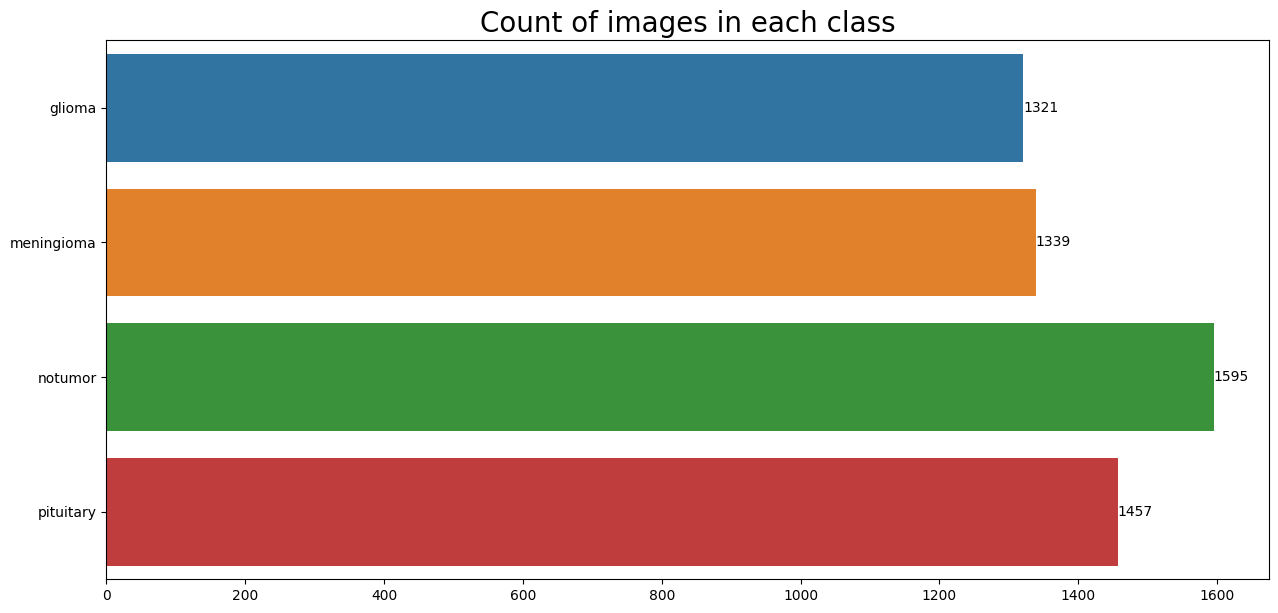

In [10]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df, y='Class')

# Remove x and y label
ax.set(xlabel='', ylabel='')

# Set the plot title
ax.set_title('Count of images in each class', fontsize=20)

# Add count labels to each bar
for container in ax.containers:
    ax.bar_label(container)

plt.show()


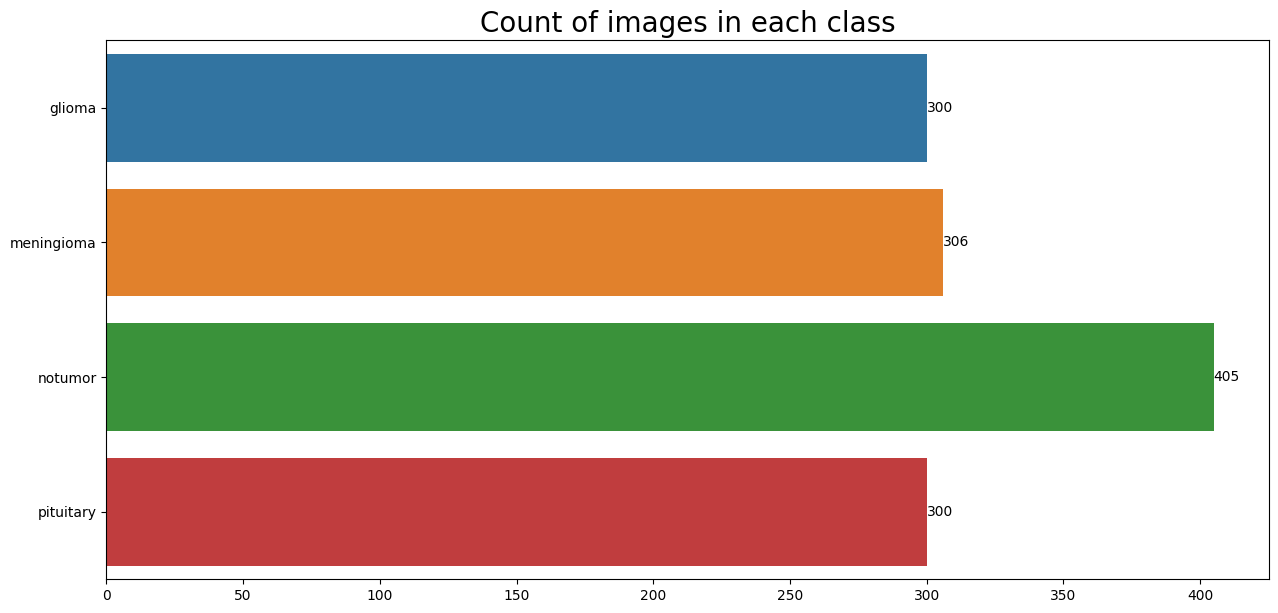

In [11]:
# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=ts_df, y='Class')

# Remove x and y label
ax.set(xlabel='', ylabel='')

# Set the plot title
ax.set_title('Count of images in each class', fontsize=20)

# Add count labels to each bar
for container in ax.containers:
    ax.bar_label(container)

plt.show()

# Data splitting

In [12]:
valid_df, ts_df = train_test_split(ts_df, train_size=.5, random_state=20)

In [13]:
valid_df

Class Path       Class
464   Testing\meningioma\Te-me_0164.jpg  meningioma
988      Testing\notumor\Te-no_0382.jpg     notumor
565   Testing\meningioma\Te-me_0265.jpg  meningioma
503   Testing\meningioma\Te-me_0203.jpg  meningioma
502   Testing\meningioma\Te-me_0202.jpg  meningioma
...                                 ...         ...
1242   Testing\pituitary\Te-pi_0231.jpg   pituitary
924      Testing\notumor\Te-no_0318.jpg     notumor
1247   Testing\pituitary\Te-pi_0236.jpg   pituitary
271       Testing\glioma\Te-gl_0271.jpg      glioma
474   Testing\meningioma\Te-me_0174.jpg  meningioma

[655 rows x 2 columns]

# Data Preprocessing

In [14]:
batch_size = 16
img_size = (299, 299)

# Training data generator with brightness augmentation
tr_gen = ImageDataGenerator(brightness_range=(0.8, 1.2))

# Generic data generator
gen = ImageDataGenerator()

# Training data generator flow from dataframe
tr_gen = tr_gen.flow_from_dataframe(
    tr_df, 
    x_col='Class Path', 
    y_col='Class', 
    batch_size=batch_size, 
    target_size=img_size
)

# Validation data generator flow from dataframe
valid_gen = gen.flow_from_dataframe(
    valid_df, 
    x_col='Class Path', 
    y_col='Class', 
    batch_size=batch_size, 
    target_size=img_size
)

# Test data generator flow from dataframe with shuffling disabled
ts_gen = gen.flow_from_dataframe(
    ts_df, 
    x_col='Class Path', 
    y_col='Class', 
    batch_size=batch_size, 
    target_size=img_size, 
    shuffle=False
)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# Data samples

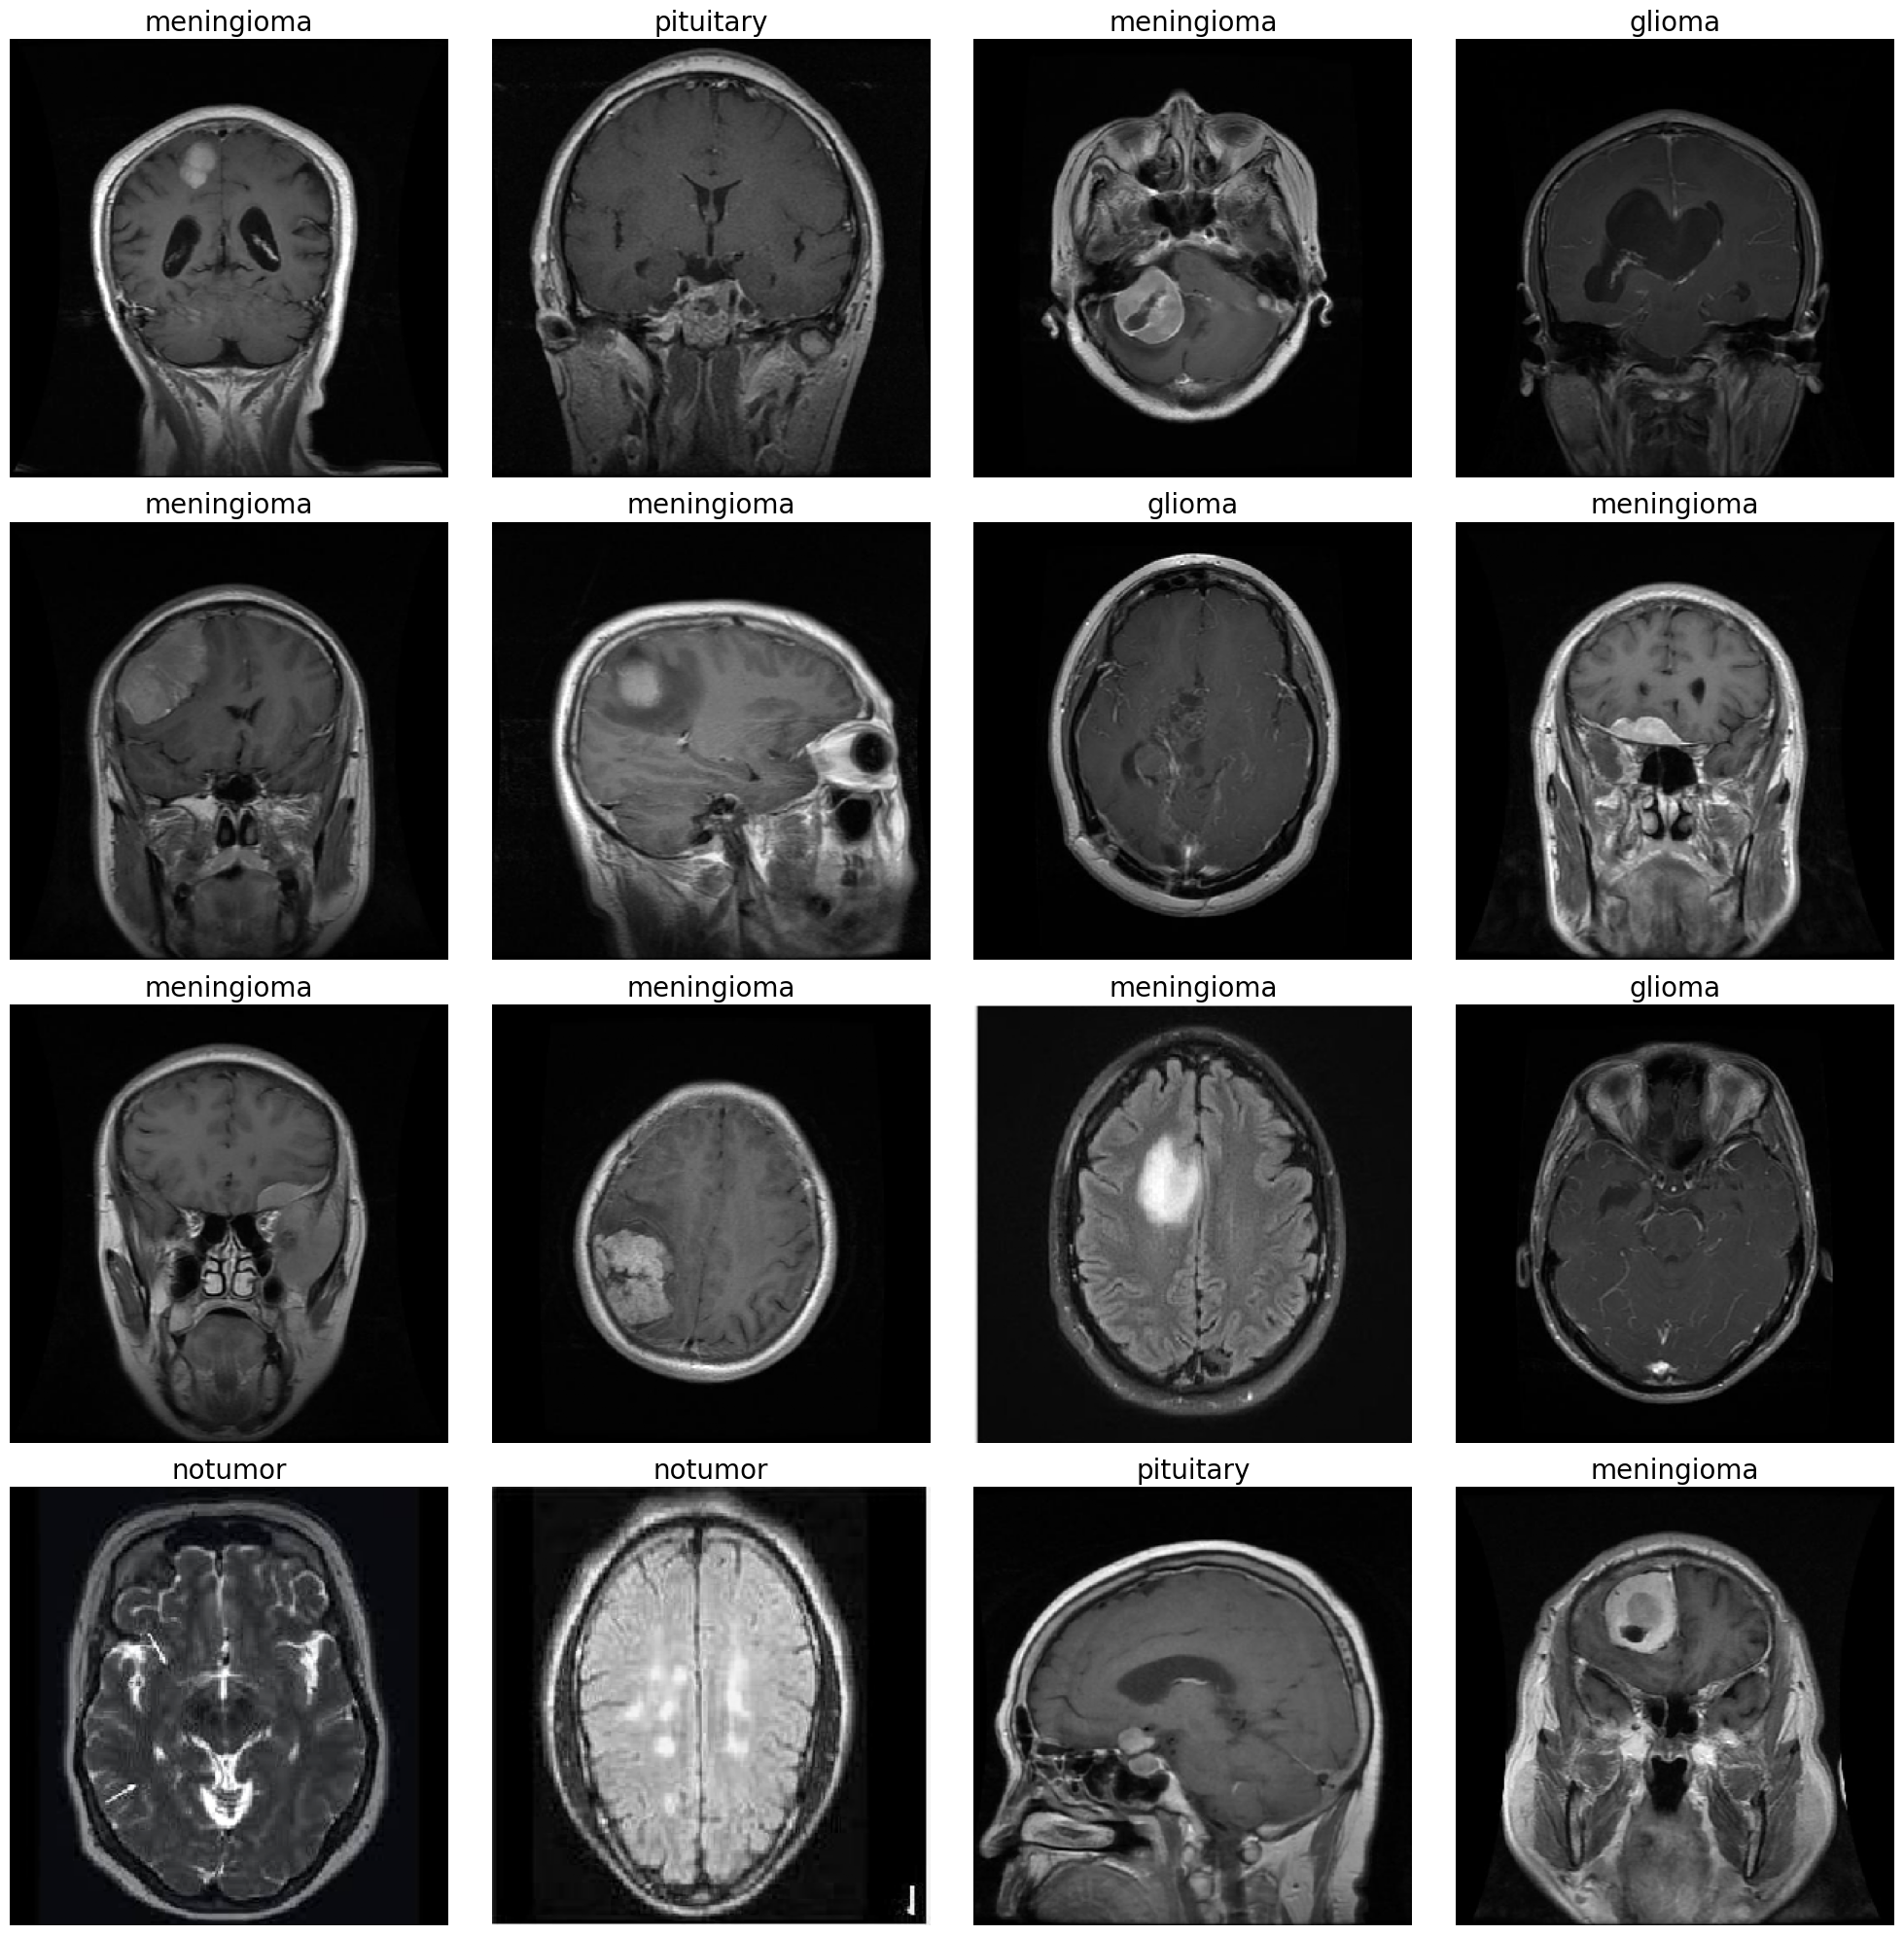

In [15]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(tr_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255.0  # Normalize image
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='k', fontsize=20)
    plt.axis('off')  # Hide axes for better visualization

plt.tight_layout()
plt.show()


In [16]:
images

array([[[[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  1.,   1.,   1.],
         [  1.,   1.,   1.],
         [  1.,   1.,   1.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  2.,   2.,   2.],
         [  2.,   2.,   2.],
         [  1.,   1.,   1.]],

        ...,

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  1.,   1.,   1.],
         ...,
         [  1.,   1.,   1.],
         [  0.,   0.,   0.],
         [  4.,   4.,   4.]],

        [[  0.,   0.,   0.],
         [  1.,   1.,   1.],
         [  2.,   2.,   2.],
         ...,
         [  2.,   2.,   2.],
         [  0.,   0.,   0.],
         [  1.,   1.,   1.]],

        [[  0.,   0.,   0.],
       

In [17]:
class_dict

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [18]:
labels

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

# Model Architecture

In [19]:
# Define input shape
img_shape = (299, 299, 3)

# Load pre-trained Xception model
base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet",
                                            input_shape=img_shape, pooling='max')

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

In [20]:
# Compile the model
model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 2106

In [22]:
# Train the model
hist = model.fit(
    tr_gen,
    epochs=10,
    validation_data=valid_gen,
    shuffle=False
)

Epoch 1/10


357/357 [==============================] - 1706s 5s/step - loss: 0.3422 - accuracy: 0.8780 - precision: 0.9234 - recall: 0.8426 - val_loss: 0.1341 - val_accuracy: 0.9588 - val_precision: 0.9585 - val_recall: 0.9527
Epoch 2/10
357/357 [==============================] - 1329s 4s/step - loss: 0.0848 - accuracy: 0.9753 - precision: 0.9770 - recall: 0.9730 - val_loss: 0.0980 - val_accuracy: 0.9679 - val_precision: 0.9782 - val_recall: 0.9603
Epoch 3/10
357/357 [==============================] - 1328s 4s/step - loss: 0.0410 - accuracy: 0.9881 - precision: 0.9884 - recall: 0.9881 - val_loss: 0.0603 - val_accuracy: 0.9786 - val_precision: 0.9801 - val_recall: 0.9786
Epoch 4/10
357/357 [==============================] - 1329s 4s/step - loss: 0.0269 - accuracy: 0.9911 - precision: 0.9923 - recall: 0.9907 - val_loss: 0.0617 - val_accuracy: 0.9802 - val_precision: 0.9802 - val_recall: 0.9802
Epoch 5/10
357/357 [==============================] - 1340s 4s/step - loss: 0.0190 - accuracy:

In [23]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

# Visualize model performance

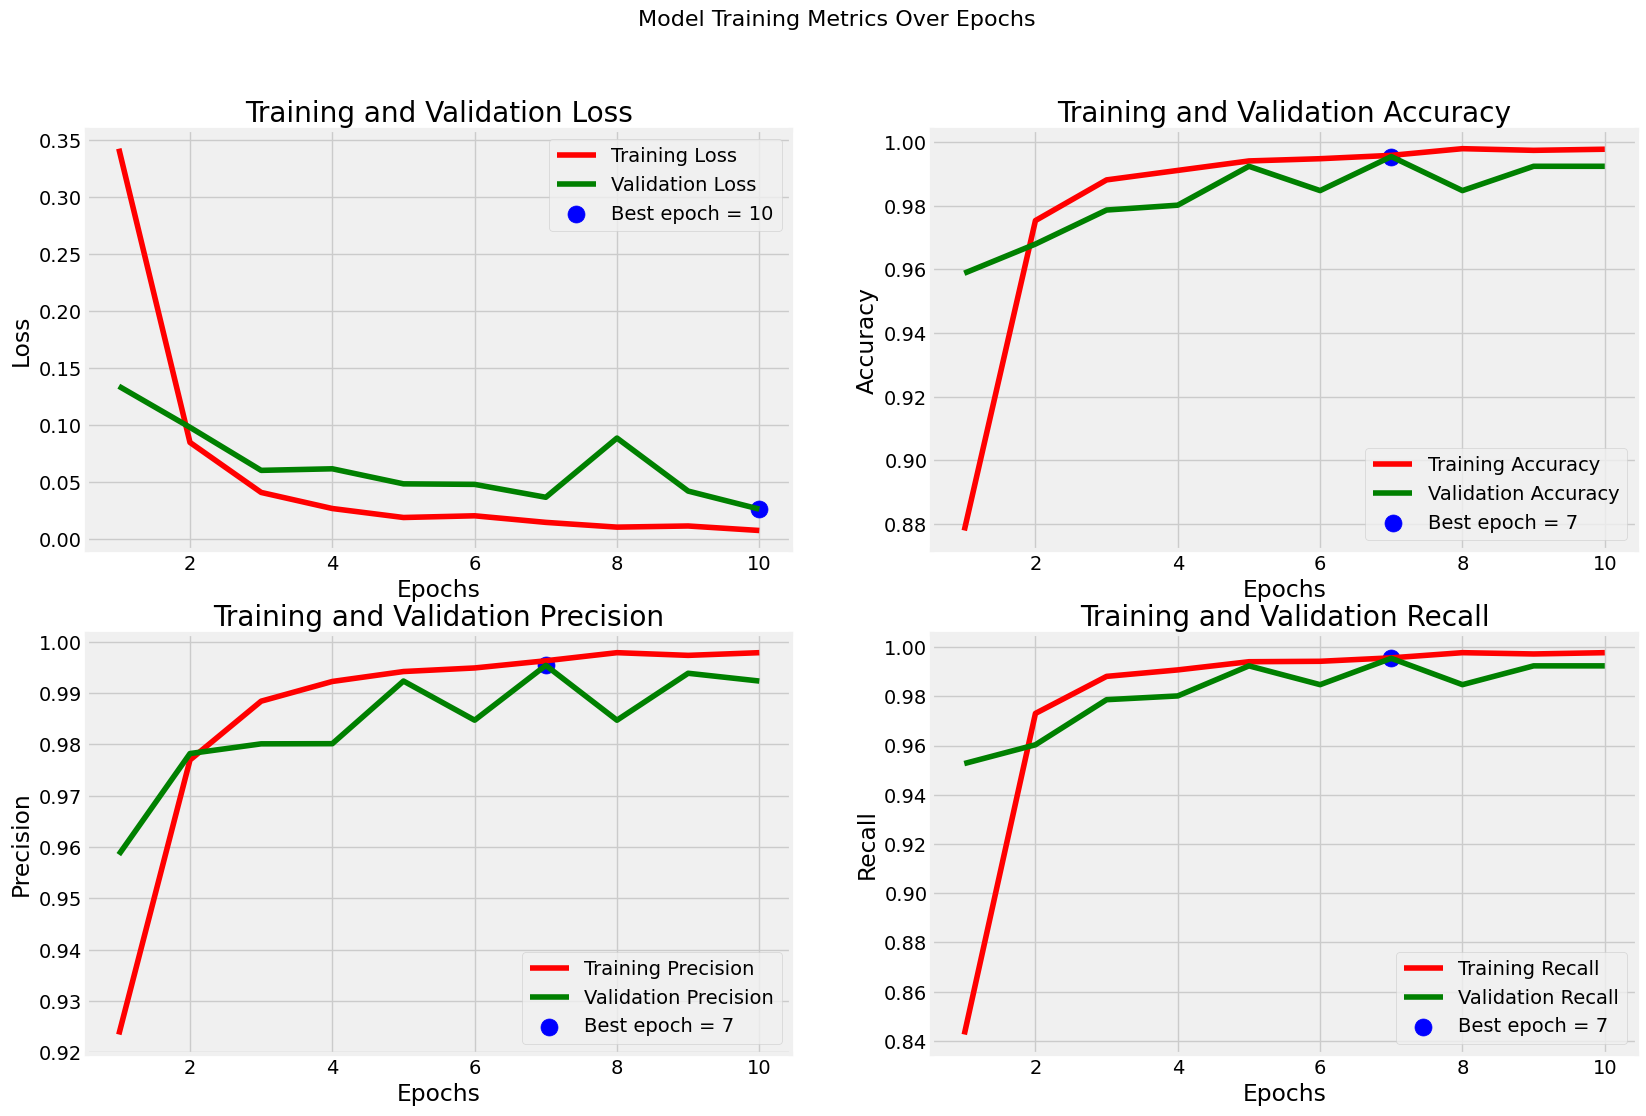

In [24]:
# Extract training and validation metrics
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

# Identify best epochs
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

# Generate epoch numbers
Epochs = [i + 1 for i in range(len(tr_acc))]

# Create labels for best epochs
loss_label = f'Best epoch = {index_loss + 1}'
acc_label = f'Best epoch = {index_acc + 1}'
per_label = f'Best epoch = {index_precision + 1}'
recall_label = f'Best epoch = {index_recall + 1}'

# Plot training and validation metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Training Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Training Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# Testing & Evaluation

In [25]:
# Evaluate the model on training data
train_score = model.evaluate(tr_gen, verbose=1)
print("Train Loss:", train_score[0])
print("Train Accuracy:", train_score[1])
print('-' * 20)

# Evaluate the model on validation data
valid_score = model.evaluate(valid_gen, verbose=1)
print("Validation Loss:", valid_score[0])
print("Validation Accuracy:", valid_score[1])
print('-' * 20)

# Evaluate the model on test data
test_score = model.evaluate(ts_gen, verbose=1)
print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])

357/357 [==============================] - 347s 970ms/step - loss: 5.7271e-04 - accuracy: 0.9998 - precision: 0.9998 - recall: 0.9998
Train Loss: 0.0005727059906348586
Train Accuracy: 0.9998249411582947
--------------------
41/41 [==============================] - 40s 968ms/step - loss: 0.0264 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924
Validation Loss: 0.02636987529695034
Validation Accuracy: 0.9923664331436157
--------------------
41/41 [==============================] - 40s 970ms/step - loss: 0.0244 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9954
Test Loss: 0.02442510612308979
Test Accuracy: 0.9954268336296082


In [26]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 40s 953ms/step


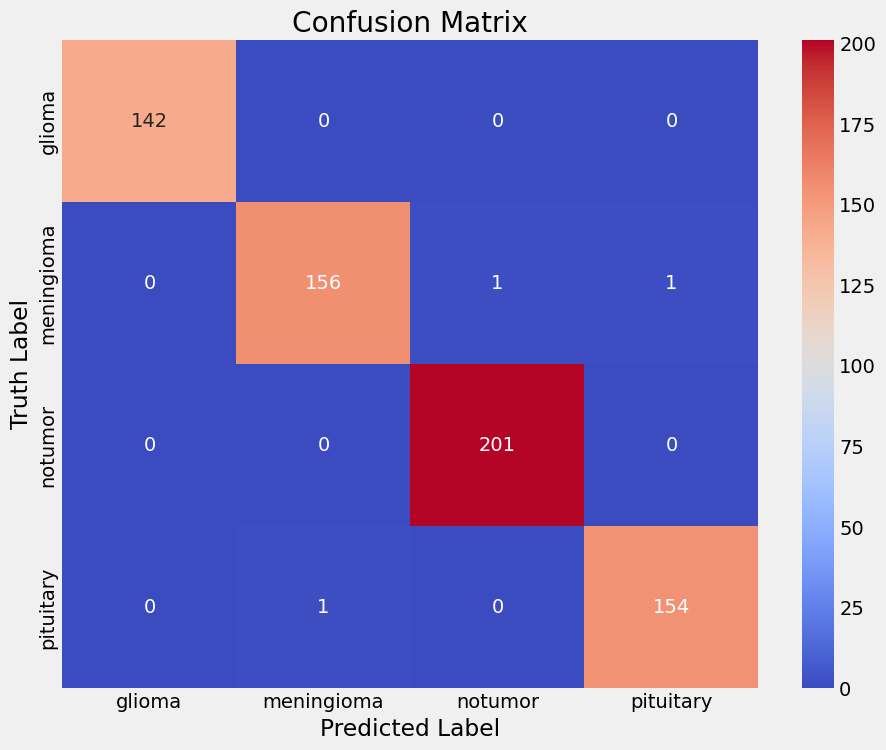

In [27]:
# Compute confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Classification report

clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       0.99      0.99      0.99       158
           2       1.00      1.00      1.00       201
           3       0.99      0.99      0.99       155

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656



# Testing

In [29]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image

    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))

    img = Image.open(img_path)
    resized_img = img.resize((299, 299))

    
    img = resized_img.convert('RGB')  

    img = np.asarray(img)
    img = np.expand_dims(img, axis=0)

    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 [==============================] - 1s 1s/step


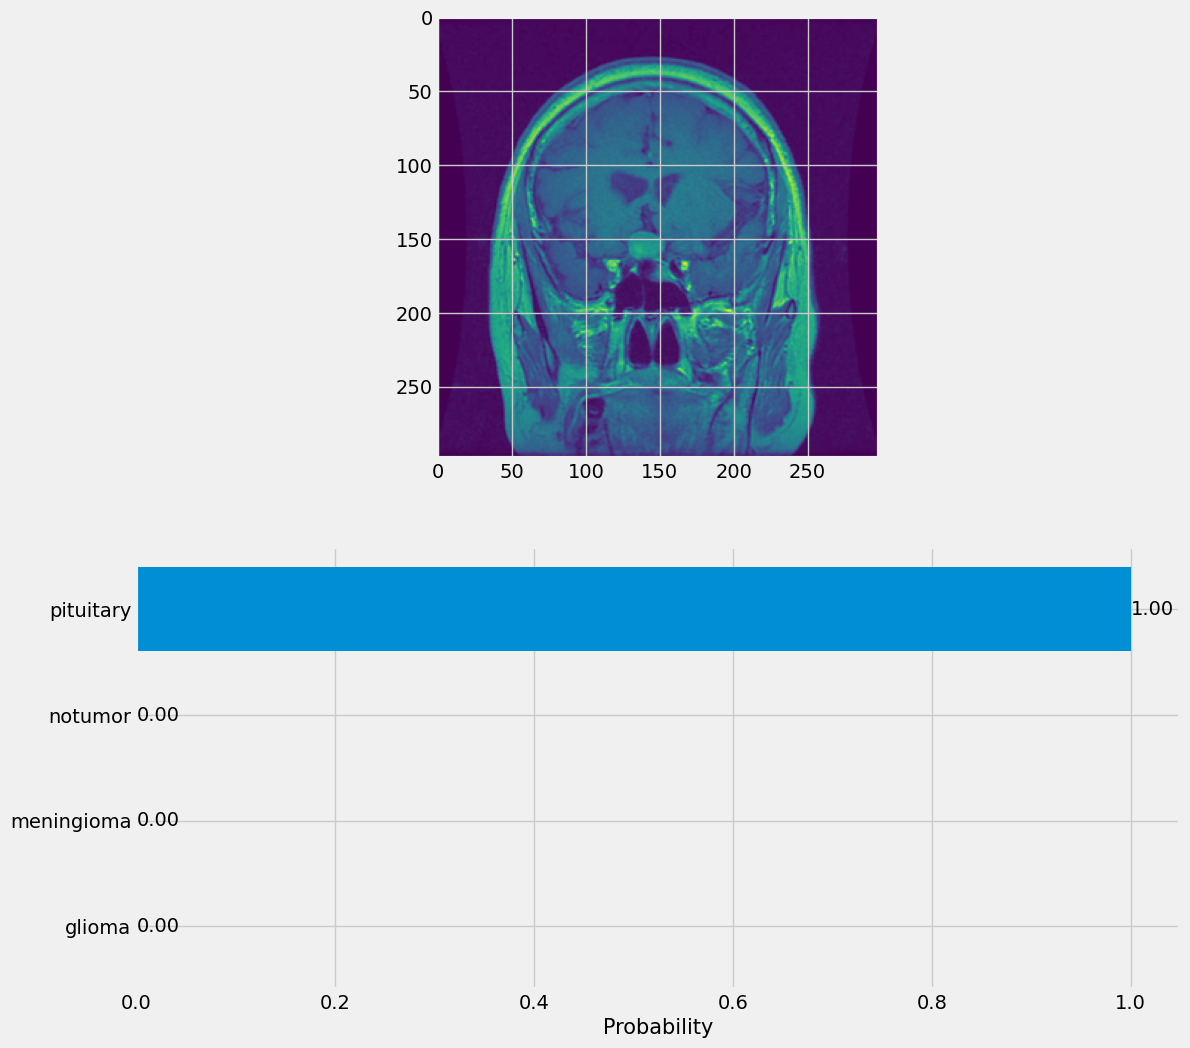

In [30]:

# Example usage
predict("Testing/pituitary/Te-pi_0236.jpg")


1/1 [==============================] - 0s 156ms/step


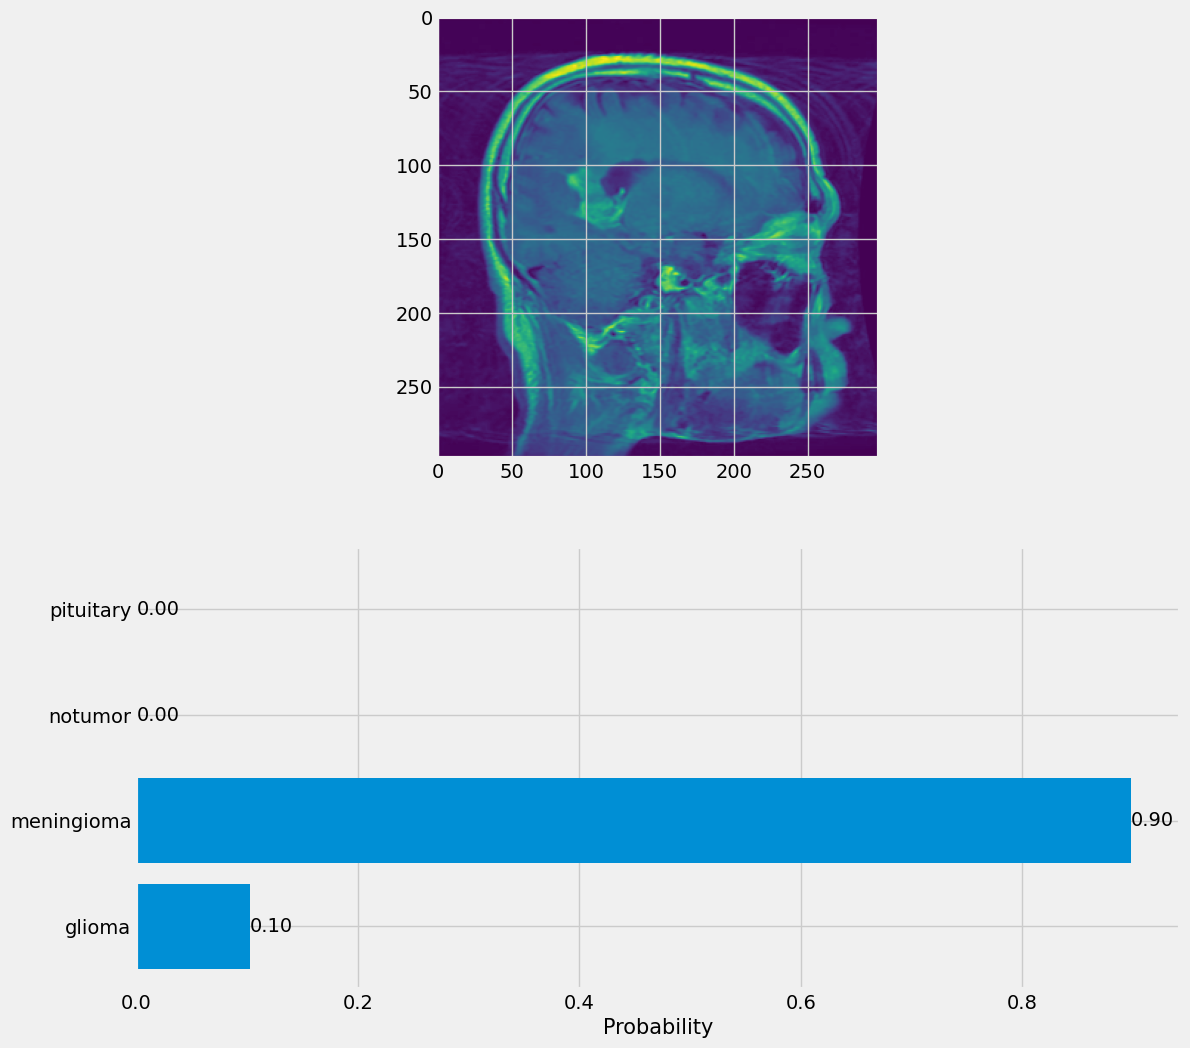

In [31]:
predict("Testing\glioma\Te-gl_0271.jpg")

1/1 [==============================] - 0s 141ms/step


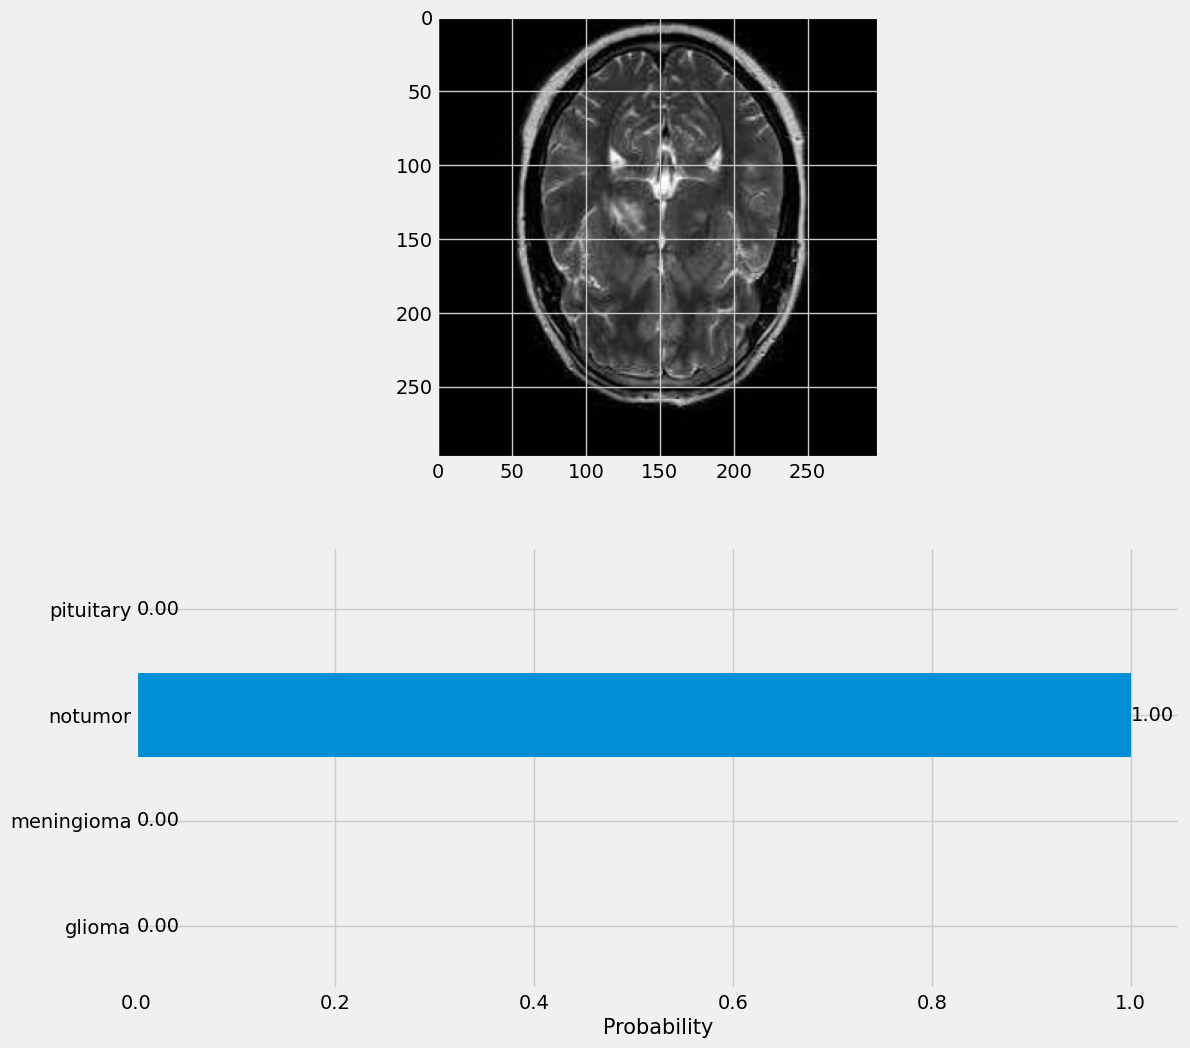

In [32]:
predict("Testing/notumor/Te-no_0318.jpg")

1/1 [==============================] - 0s 115ms/step


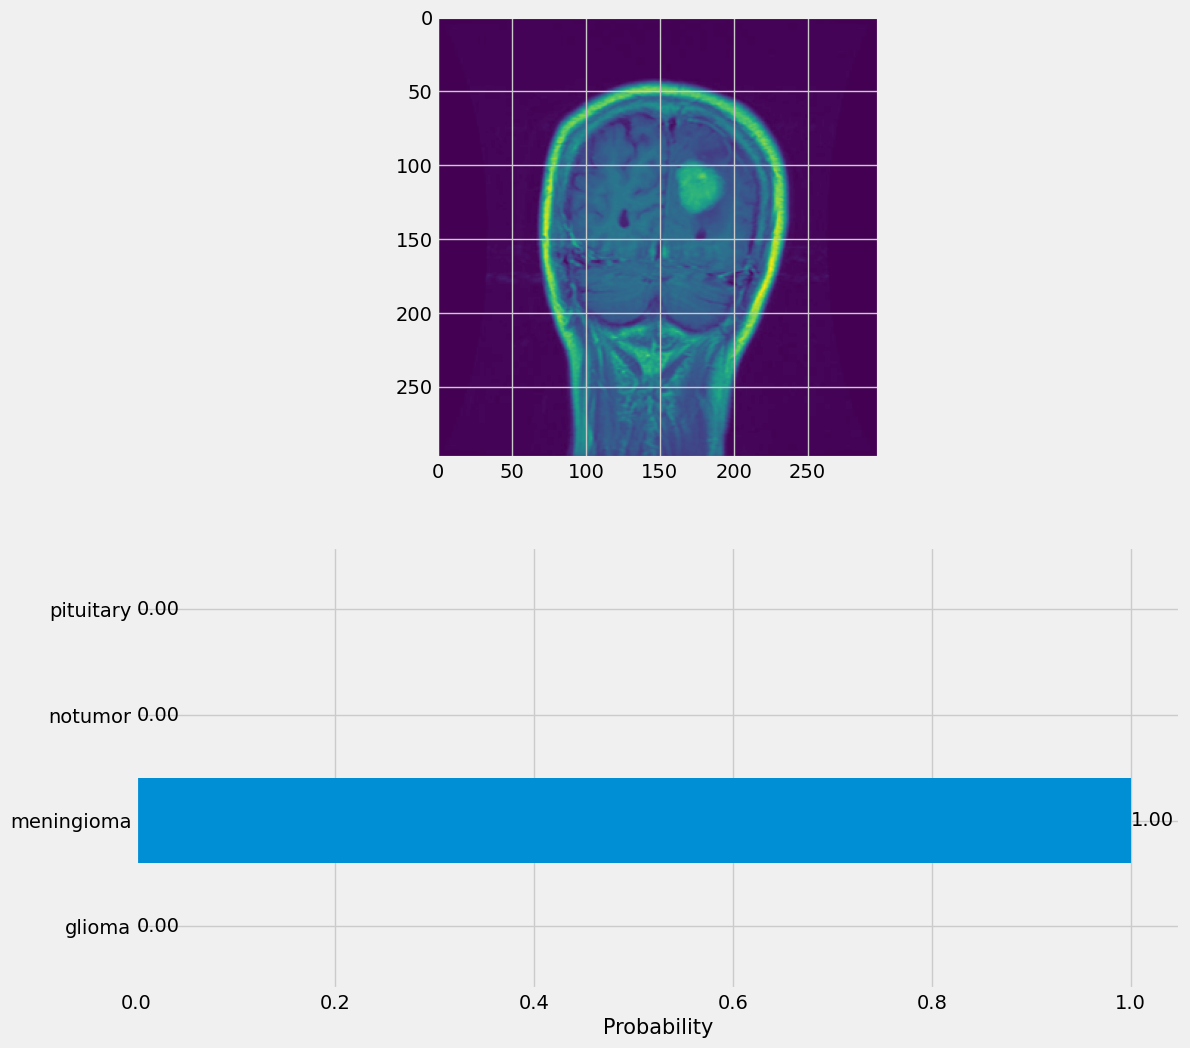

In [33]:
predict("Testing\meningioma\Te-me_0174.jpg")

1/1 [==============================] - 0s 321ms/step


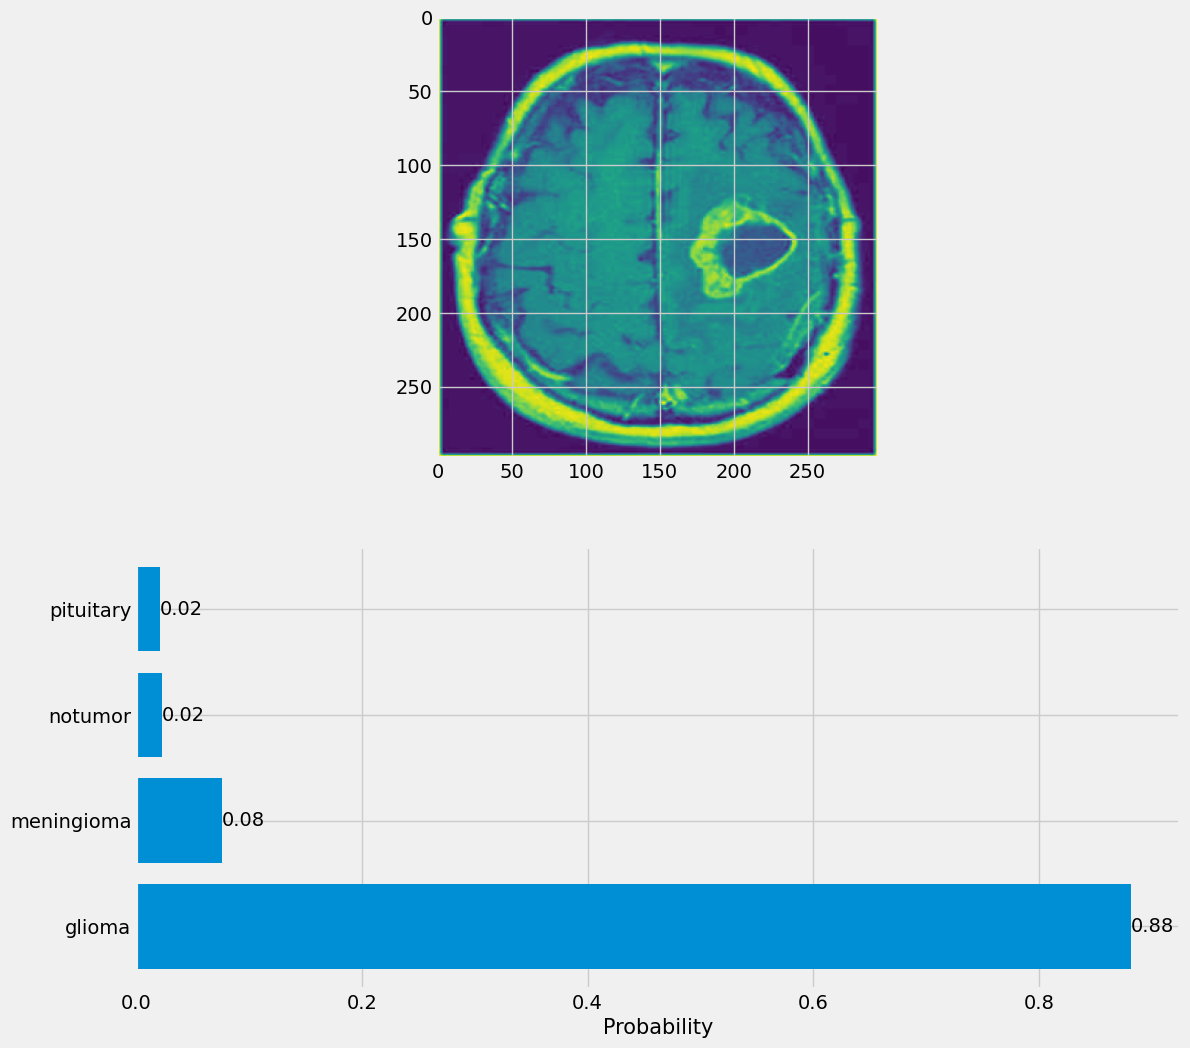

In [35]:
predict(r"C:\Users\anuj\Desktop\Summer 24\BrainTumor\glioma.jpg")

1/1 [==============================] - 0s 313ms/step


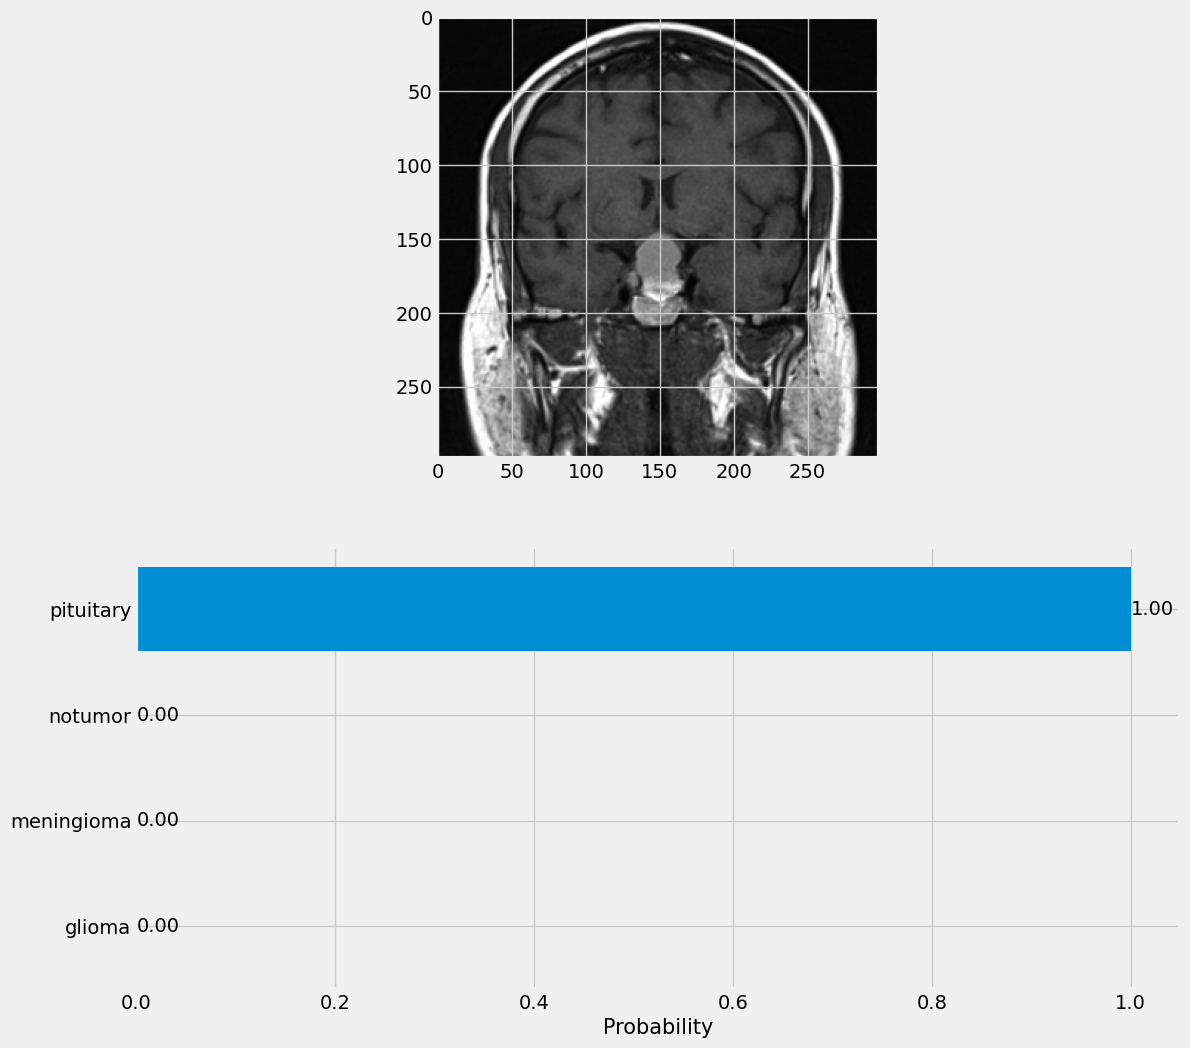

In [36]:
predict(r"C:\Users\anuj\Desktop\Summer 24\BrainTumor\pituitary.jpeg")

1/1 [==============================] - 0s 320ms/step


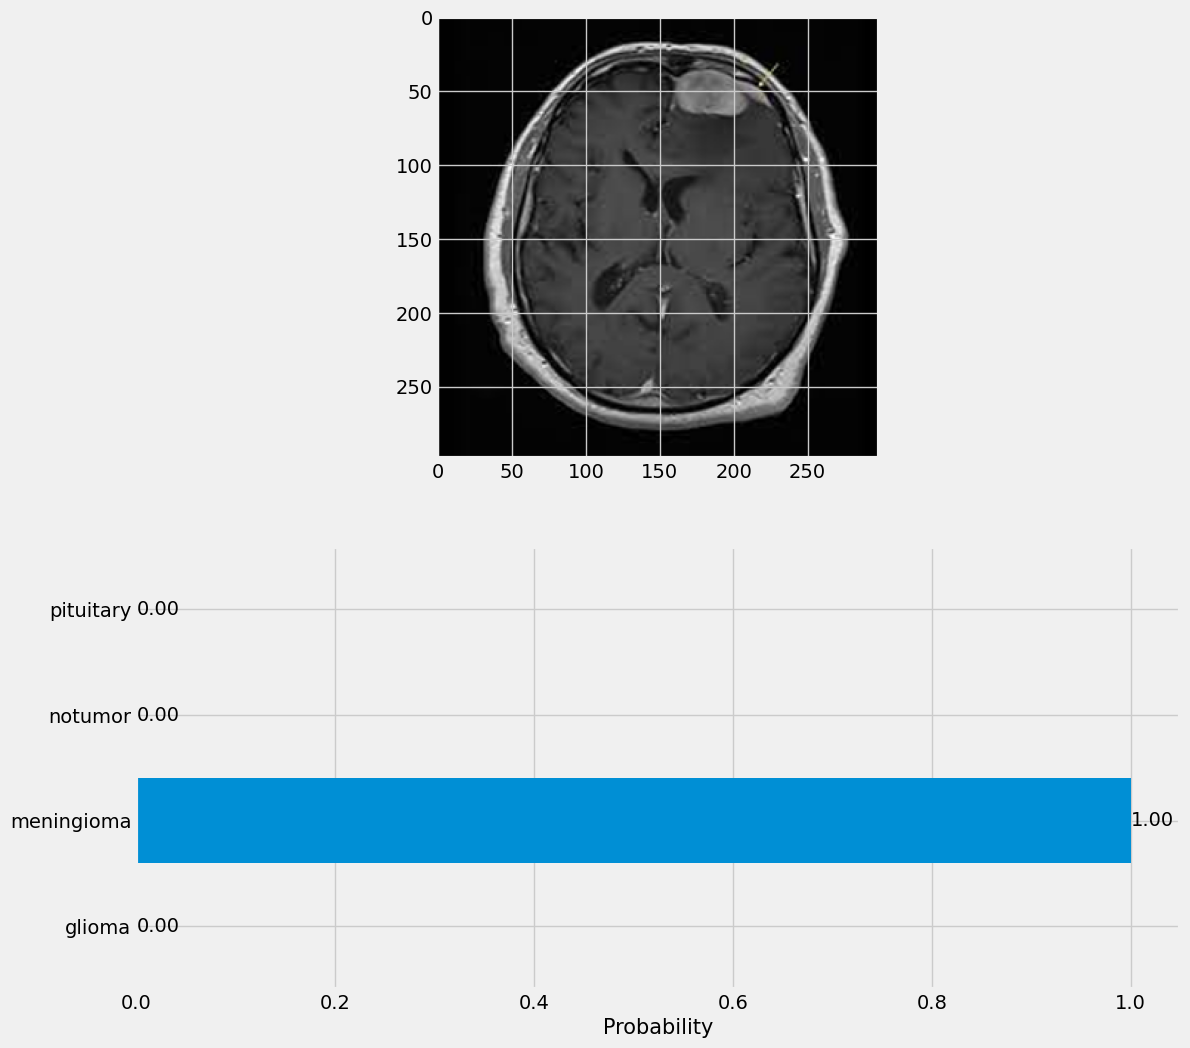

In [37]:
predict(r"C:\Users\anuj\Desktop\Summer 24\BrainTumor\meningioma.jpeg")

1